In [1]:
!pip install ortools matplotlib folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.2

In [2]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import folium

In [14]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["time_matrix"] = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
    ]
    data["time_windows"] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (16, 18),  # 3
        (10, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 4),  # 7
        (5, 10),  # 8
        (0, 3),  # 9
        (10, 16),  # 10
        (10, 15),  # 11
        (0, 5),  # 12
        (5, 10),  # 13
        (7, 8),  # 14
        (10, 15),  # 15
        (11, 15),  # 16
    ]
    time_windows = data['time_windows']

    data['num_vehicles'] = 4
    data['depot'] = 0
    data['num_locations'] = len(time_windows)
    data['demands'] = [0] * data['num_locations']
    return data

In [5]:
def plot_routes(data, manager, routing, solution):
    """Plot routes using Matplotlib."""
    fig, ax = plt.subplots(figsize=(10, 10))

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        route.append(manager.IndexToNode(routing.Start(vehicle_id)))

        # Plot route
        x = [data['locations'][i][0] for i in route]
        y = [data['locations'][i][1] for i in route]
        ax.plot(x, y, 'o-', label=f'Vehicle {vehicle_id}')

    ax.legend()
    ax.set_title('Vehicle Routes')
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.grid(True)
    plt.show()

In [6]:
def plot_map(data, manager, routing, solution):
    """Plot routes on an interactive map using Folium."""
    m = folium.Map(location=data['depot'], zoom_start=10)

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        route.append(manager.IndexToNode(routing.Start(vehicle_id)))

        # Plot route
        points = [(data['locations'][i][0], data['locations'][i][1]) for i in route]
        folium.PolyLine(points, color=f'#{vehicle_id}0000', weight=5, opacity=0.7).add_to(m)

    folium.Marker(data['depot'], popup='Depot', icon=folium.Icon(color='green')).add_to(m)
    for i, loc in enumerate(data['locations']):
        folium.Marker(loc, popup=f'Location {i}').add_to(m)

    m.save('vrptw_map.html')
    print('Map saved as vrptw_map.html')

In [7]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console and visualize routes."""
    max_route_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = [manager.IndexToNode(index)]
        route_time = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_time += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
            route.append(node_index)

        max_route_time = max(route_time, max_route_time)

    print('Maximum of the route times: {}min'.format(max_route_time))

    plot_routes(data, manager, routing, solution)
    plot_map(data, manager, routing, solution)

In [8]:
def main():
    """Solve the VRPTW problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(data['num_locations'], data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return abs(data['time_windows'][from_node][1] - data['time_windows'][to_node][0])

    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Time Windows constraint.
    time = 'Time'
    routing.AddDimension(
        transit_callback_index,
        30,  # allow waiting time
        30,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0 or location_idx == (data['num_locations'] - 1):
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

    # Add capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        [20] * data['num_vehicles'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)

Maximum of the route times: 0min


KeyError: 'locations'

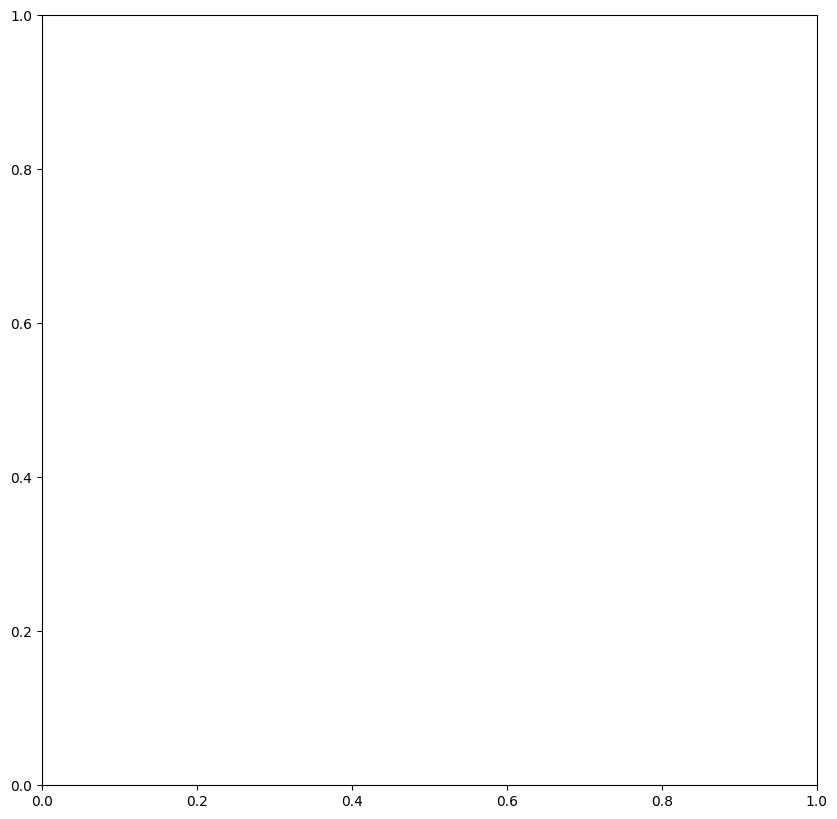

In [15]:
if __name__ == '__main__':
    main()

In [16]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import folium

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Locations in block units
    data['locations'] = [
        (4, 4),  # depot
        (2, 0), (8, 0),  # locations to visit
        (0, 1), (1, 1),
        (5, 2), (7, 2),
        (3, 3), (6, 3),
        (5, 5), (8, 5),
        (1, 6), (2, 6),
        (3, 7), (6, 7),
        (0, 8), (7, 8)
    ]
    data['num_locations'] = len(data['locations'])
    data['num_vehicles'] = 4
    data['depot'] = 0
    data['time_windows'] = [
        (0, 0),  # depot
        (75, 85), (75, 85),  # 1, 2
        (60, 70), (45, 55),  # 3, 4
        (0, 8), (50, 60),  # 5, 6
        (0, 10), (10, 20),  # 7, 8
        (0, 10), (75, 85),  # 9, 10
        (85, 95), (5, 15),  # 11, 12
        (15, 25), (10, 20),  # 13, 14
        (45, 55), (30, 40)  # 15, 16
    ]
    data['demands'] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
    data['vehicle_capacities'] = [15, 15, 15, 15]
    data['time_per_demand_unit'] = 5
    data['vehicle_speed'] = 1

    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_time = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            plan_output += ' {} Time({}-{}) -> '.format(node_index, solution.Min(time_dimension.CumulVar(index)),
                                                        solution.Max(time_dimension.CumulVar(index)))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_time += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        node_index = manager.IndexToNode(index)
        plan_output += ' {} Time({}-{})\n'.format(node_index, solution.Min(time_dimension.CumulVar(index)),
                                                  solution.Max(time_dimension.CumulVar(index)))
        plan_output += 'Time of the route: {}min\n'.format(route_time)
        print(plan_output)
        total_time += route_time
    print('Total time of all routes: {}min'.format(total_time))


def plot_routes(data, manager, routing, solution):
    """Plot routes using Matplotlib."""
    fig, ax = plt.subplots(figsize=(10, 10))

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        route.append(manager.IndexToNode(routing.Start(vehicle_id)))

        # Plot route
        x = [data['locations'][i][0] for i in route]
        y = [data['locations'][i][1] for i in route]
        ax.plot(x, y, 'o-', label=f'Vehicle {vehicle_id}')

    ax.legend()
    ax.set_title('Vehicle Routes')
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.grid(True)
    plt.show()


def plot_map(data, manager, routing, solution):
    """Plot routes on an interactive map using Folium."""
    m = folium.Map(location=data['locations'][data['depot']], zoom_start=12)

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        route.append(manager.IndexToNode(routing.Start(vehicle_id)))

        # Plot route
        points = [(data['locations'][i][0], data['locations'][i][1]) for i in route]
        folium.PolyLine(points, color=f'#{vehicle_id}0000', weight=5, opacity=0.7).add_to(m)

    folium.Marker(data['locations'][data['depot']], popup='Depot', icon=folium.Icon(color='green')).add_to(m)
    for i, loc in enumerate(data['locations']):
        if i != data['depot']:
            folium.Marker(loc, popup=f'Location {i}').add_to(m)

    m.save('vrptw_map.html')
    print('Map saved as vrptw_map.html')


def main():
    """Solve the VRPTW problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(data['num_locations'], data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return abs(data['locations'][from_node][0] - data['locations'][to_node][0]) + \
               abs(data['locations'][from_node][1] - data['locations'][to_node][1])

    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Time Windows constraint.
    time = 'Time'
    routing.AddDimension(
        transit_callback_index,
        30,  # allow waiting time
        30,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0 or location_idx == (data['num_locations'] - 1):
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

    # Add capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console and visualize routes.
    if solution:
        print_solution(data, manager, routing, solution)
        plot_routes(data, manager, routing, solution)
        plot_map(data, manager, routing, solution)


if __name__ == '__main__':
    main()


Exception: CP Solver fail